### Installing dependency



In [1]:
import torch, torchvision
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab\ Notebooks
!pip install mmcv -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
#!git clone https://github.com/open-mmlab/mmclassification.git
%cd mmclassification/
!pip install -e .
!mkdir checkpoints
!mkdir work_dirs/xietong_transformer_v2_large
import mmcls
print(mmcls.__version__)

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu111/torch1.9.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 605.4/605.4 KB 11.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.2/190.2 KB 5.6 MB/s eta 0:00:00
  Created wheel for mmcv: filename=mmcv-1.7.1-py2.py3-none-any.whl size=930735 sha256=494fee9a7c904c1f511eed122abff94ee1a72855aa6824f99cf05d8385e5c305
  Stored in directory: /root/.cache/pip/wheels/74/0c/f4/cafa17bca99a907f0ea624325aec45e905dd44884a47eae0bf
Successfully built mmcv
/content/drive/MyDrive/Colab Notebooks/mmclassification
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/Colab%20Notebooks/mmclassification
  Preparing metadata (setup.py) ..

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [2]:
%%writefile configs/swin_transformer/xietong_transformer_v2_large.py
_base_ = [
    '../_base_/models/swin_transformer_v2/large_384.py',
    '../_base_/datasets/imagenet_bs64_swin_384.py',
    '../_base_/schedules/imagenet_bs1024_adamw_swin.py',
    '../_base_/default_runtime.py'
]

model = dict(
    backbone=dict(
        init_cfg = dict(
            type='Pretrained', 
            checkpoint="https://download.openmmlab.com/mmclassification/v0/swin-v2/swinv2-large-w24_in21k-pre_3rdparty_in1k-384px_20220803-3b36c165.pth", 
            prefix='backbone')
    ),
    head=dict(
        num_classes=2,
        topk = (1, )
    ),
    train_cfg=dict(augments=[
        dict(type='BatchMixup', alpha=0.8, num_classes=2, prob=0.5),
        dict(type='BatchCutMix', alpha=1.0, num_classes=2, prob=0.5)
    ])
    )

img_norm_cfg = dict(
     mean=[124.508, 116.050, 106.438],
     std=[58.577, 57.310, 57.437],
     to_rgb=True)

dataset_type = 'CustomDataset'
classes = ['0', '1']  

data = dict(
    # 每个 gpu 上的 batch size 和 num_workers 设置，根据计算机情况设置
    samples_per_gpu = 16,
    workers_per_gpu=2,
    # 指定训练集路径
    train = dict(
        #data_prefix = 'data/cats_dogs_dataset/training_set/training_set',
        #classes = 'data/cats_dogs_dataset/classes.txt'
        
        data_prefix = 'data/mono/train',
        classes = 'data/mono/class.txt'
    ),
    # 指定验证集路径
    val = dict(
        #data_prefix = 'data/cats_dogs_dataset/val_set/val_set',
        #ann_file = 'data/cats_dogs_dataset/val.txt',
        #classes = 'data/cats_dogs_dataset/classes.txt'

        data_prefix = 'data/mono/val',
        ann_file = 'data/mono/val.txt',
        classes = 'data/mono/class.txt'
    ),
    # 指定测试集路径
    test = dict(
        #data_prefix = 'data/cats_dogs_dataset/test_set/test_set',
        #ann_file = 'data/cats_dogs_dataset/test.txt',
        #classes = 'data/cats_dogs_dataset/classes.txt'

        data_prefix = 'data/mono/test',
        ann_file = 'data/mono/test.txt',
        classes = 'data/mono/class.txt'
    )
)
# 修改评估指标设置
evaluation = dict(interval=1, metric='accuracy', metric_options={'topk': (1, )})

# for batch in each gpu is 128, 8 gpu
# lr = 5e-4 * 128 * 8 / 512 = 0.001
optimizer = dict(lr=5e-4 * 16 * 1 / 512)

# learning policy
lr_config = dict(
    policy='CosineAnnealing',
    by_epoch=False,
    min_lr_ratio=1e-1,
    warmup='linear',
    warmup_ratio=1e-1,
    warmup_iters=100,
    warmup_by_epoch=False)

runner = dict(max_epochs=40)



Writing configs/swin_transformer/xietong_transformer_v2_large.py


In [3]:
!python tools/train.py \
  configs/swin_transformer/xietong_transformer_v2_large.py \
  --work-dir work_dirs/xietong_transformer_v2_large \
  --seed 0 \
  --deterministic

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/content/drive/MyDrive/Colab Notebooks/mmclassification/mmcls/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal per

In [4]:
!python tools/test.py ./configs/swin_transformer/xietong_transformer_v2_large.py work_dirs/xietong_transformer_v2_large/epoch_2.pth --metrics=accuracy --metric-options=topk=1

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/content/drive/MyDrive/Colab Notebooks/mmclassification/mmcls/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal per

In [5]:
!python tools/test.py ./configs/swin_transformer/xietong_transformer_v2_large.py work_dirs/xietong_transformer_v2_large/epoch_2.pth --out=results.json

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/content/drive/MyDrive/Colab Notebooks/mmclassification/mmcls/utils/setup_env.py:32: UserWarning: Setting OMP_NUM_THREADS environment variable for each process to be 1 in default, to avoid your system being overloaded, please further tune the variable for optimal per

Test set inference



Image path: ./data/mono/test/0/cell1192.png
class_scores: [0.9741344451904297, 0.025865504518151283]
defeat_probability: 0
pred_score: 0.9741344451904297


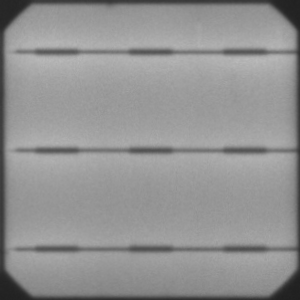

In [6]:
import json
from PIL import Image
with open("./results.json", 'r') as f:
    results = json.load(f)


order = 6
mapper = {0:0, 1:0.3333, 2:0.666, 3:1}
with open("data/mono/test.txt") as file:
    lines = [line.rstrip() for line in file]


#Show the inference result of the test set
print('Image path: ./data/mono/test/' + lines[order].split()[0])
print('class_scores:', results['class_scores'][order])
#print('pred_class:', results['pred_class'][order])
print('defeat_probability:', mapper[results['pred_label'][order]])
print('pred_score:', results['pred_score'][order])  
Image.open('data/mono/test/' + lines[order].split()[0])

In [7]:
!python demo/image_demo.py ./data/mono/test/0/cell1006.png ./configs/swin_transformer/xietong_transformer_v2_large.py work_dirs/xietong_transformer_v2_large/epoch_2.pth

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/mmcv/cnn/bricks/transformer.py:33: UserWarning: Fail to import ``MultiScaleDeformableAttention`` from ``mmcv.ops.multi_scale_deform_attn``, You should install ``mmcv-full`` if you need this module. 
  warnings.warn('Fail to import ``MultiScaleDeformableAttention`` from '
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tenso